# Imports

In [166]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss, epsilon_decay
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np
import gym
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import pandas as pd
import csv
import copy
import pickle
import json

# Parameter Options for Grid Search

In [171]:
NUM_RUNS = 10
episode_duration = 300

# When using grid search
param_grid = {
    'architecture': [[4, 18, 18, 2]],
    'learning_rate': [0.005],
    'optimizer': [optim.Adam],
    'batch_size': [500],
    'replay_buffer_size': [15000],
    'epsilon_decay_config': [(1, 0, 250)],
}

# When using custom parameter sequence, changing only 1 hyperparameter at a time from the base hyperparameters 
param_base = {
    'architecture': [4, 18, 18, 2],
    'learning_rate': 0.005,
    'optimizer': optim.Adam,
    'batch_size': 500,
    'replay_buffer_size': 15000,
    'epsilon_decay_config': (1, 0, 250)
}

param_sequence = { # parameter values to cycle through (leave blank if only base value is required and no other values are needed for testing)
    'architecture': [[4, 18, 2],[4, 18, 18, 2],[4, 18, 18, 18, 2], [4, 5, 5, 2], [4, 10, 10, 2], [4, 15, 15, 2]],
    'learning_rate': [0.001, 0.005, 0.01, 0.02],
    'optimizer': [],
    'batch_size': [100, 300, 500, 700],
    'replay_buffer_size': [9000, 12000, 15000, 18000],
    'epsilon_decay_config': [(1, 0, 150), (1, 0, 200), (1, 0, 250), (1, 0, 300)],
}

# Dataframe to contain results, initialisation
param_names = ['architecture', 'learning_rate', 'optimizer', 'batch_size', 'replay_buffer_size', 'epsilon_decay_config']
model_tracker_columns = param_names + ['means']
model_tracker = pd.DataFrame(columns=model_tracker_columns)

# Select grid search or Custom Parameter Sequence search
option_grid_search = False
option_custom_sequence = True

# DQN Model

In [40]:
def run_dqn(params):
    """Run DQN model according to parameters and number of runs

    Args:
        params: a dictionary containing all parameters necessary. These include
            - Architecture (list) : list of integers where each integer is the number of nodes in a layer
            - Learning rate (int) : how much the model weights recent experiences (0 -> 1)
            - Optimiser (optim) : Adam, SGD
            - Batch / sample size (int) : Number of samples taken from replay buffer
            - ReplayBuffer size (int) : capacity of replay bufer
            - Epsilon (list) : parameters for epsilon to decay 
    
    Returns:
        
    """

    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(NUM_RUNS):
        print(f"Starting run {run+1} of {NUM_RUNS}")
        policy_net = DQN(params['architecture'])
        target_net = DQN(params['architecture'])
        update_target(target_net, policy_net)
        target_net.eval()

        optimizer = optim.Adam(policy_net.parameters(), lr=params['learning_rate'])
        memory = ReplayBuffer(params['replay_buffer_size'])

        episode_durations = []

        for i_episode in range(episode_duration):
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", episode_duration)
                
            EPSILON = epsilon_decay(params['epsilon_decay_config'][0], params['epsilon_decay_config'][1], params['epsilon_decay_config'][2], i_episode)

            observation, info = env.reset()
            state = torch.tensor(observation).float()

            done = False
            terminated = False
            t = 0
            while not (done or terminated):

                # Select and perform an action                
                action = epsilon_greedy(EPSILON, policy_net, state)                
                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < 1:
                    transitions = memory.sample(params['batch_size'])
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            if i_episode % 1 == 0: 
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')
    return runs_results, policy_net

# Option 1: Run Grid Search

In [21]:
if option_grid_search is True:
    # initialise best parameter and best performance trackers
    best_params = None
    best_performance = float('-inf')
    best_results = None

    # initialise empty dict to record performance for all parameter combinations
    performance_dict = {}
    count = 1
    for architecture in param_grid['architecture']:
        for learning_rate in param_grid['learning_rate']:
            for optimizer in param_grid['optimizer']:
                for batch_size in param_grid['batch_size']:
                    for replay_buffer_size in param_grid['replay_buffer_size']:
                        for epsilon_decay_config in param_grid['epsilon_decay_config']:
                            params = {
                                'architecture': architecture,
                                'learning_rate': learning_rate,
                                'optimizer': optimizer,
                                'batch_size': batch_size,
                                'replay_buffer_size': replay_buffer_size,
                                'epsilon_decay_config': epsilon_decay_config,
                            }
                            
                            # Run DQN with parameter combinations
                            results = run_dqn(params)
                            
                            # Record performance across all runs and episodes
                            performance_dict[str(params)] = results
                            
                            # Evaluate the performance (you may choose a different metric)
                            average_performance = sum(sum(run) for run in results) / NUM_RUNS

                            # Update best hyperparameters if needed
                            if average_performance > best_performance:
                                best_params = params
                                best_performance = average_performance
                                best_results = results
                            
                            print(f'Finished Param Combo: {count}')
                            count += 1

    # Print best hyperparameters
    print("Best Hyperparameters:", best_params)

# Option 2: Run Custom Parameter Sequence

In [172]:
# if option_grid_search is false, then commence custom parameter sequence runs
if option_custom_sequence:
    # initialise best parameter and best performance trackers
    best_params = None
    best_performance = float('-inf')
    best_results = None
    performance_dict = {}
    count = 1
    # for every parameter, loop through the custom sequence of parameter values, deviating only from the base hyperparameter configuration
    for param_name in param_names:
        
        params = copy.deepcopy(param_base) # Initialise the base parameters at the start of every loop so that it only deviates from the base
        
        for param_value in param_sequence[param_name]: # for every parameter value in the hyperparameter's list of values
            params[param_name] = param_value # change the parameter value from base to new value
            
            # Run DQN with 1 value different from the base configuration
            results, policy_net = run_dqn(params)
            
            # Record performance across all runs and episodes
            performance_dict[str(params)] = results
            
            # Evaluate the performance (you may choose a different metric)
            print(results)
            average_performance = sum(sum(run) for run in results) / NUM_RUNS

            # Update best hyperparameters if needed
            if average_performance > best_performance:
                best_params = params.copy()
                best_performance = average_performance
                best_results = results.copy()
            
            # calculate the means of the model performance across X runs
            results = torch.tensor(results)
            means = results.float().mean(0)
            
            print(f'Finished Param Combo: {count}')
            count += 1
            
            
# Save performance_dict to a JSON file
json_file_path = 'performance_dict.json'

with open(json_file_path, 'w') as json_file:
    json.dump(performance_dict, json_file)

print(f'Dictionary has been saved to {json_file_path}')

Starting run 1 of 5


/Users/kyhi2018/Desktop/Imperial/Reinforcement Learning/CW2/RL-Deep-Q-Learning/venv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 5
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 5
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 5
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 5
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
[[23, 15, 10, 8, 10, 13, 9, 8, 9, 22, 9, 18, 11, 12, 15, 11, 13, 23, 16, 14, 20, 22, 32, 50, 117, 103, 181, 123, 74, 116, 99, 108, 106, 118, 142, 193, 155, 144, 136, 165, 165, 156, 204, 149, 117, 119, 129, 185, 143, 174, 141, 163, 146, 187, 210, 184, 149, 145, 143, 136, 133, 132, 127, 116, 138, 139, 165, 146, 138, 138, 133, 122, 126, 156, 129, 

# Plotting Best Results

86131.0
{'architecture': [4, 18, 18, 2], 'learning_rate': 0.005, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_size': 500, 'replay_buffer_size': 9000, 'epsilon_decay_config': (1, 0, 250)}


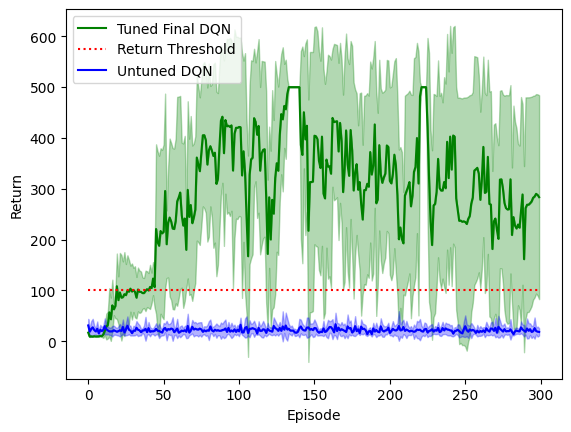

In [218]:
best_performance = 0

for key, value in performance_dict.items():
    sum_performance = sum(sum(run) for run in value) / NUM_RUNS
    if sum_performance > best_performance:
        best_performance = sum_performance
        best_key = key

print(best_performance)
print(best_key)

results = torch.tensor(performance_dict[best_key])
means = results.float().mean(0)
stds = results.float().std(0)

plt.plot(torch.arange(episode_duration), means,color='g', label='Tuned Final DQN')
plt.plot(torch.arange(episode_duration), torch.full((episode_duration,), 100), color='red', linestyle='dotted', label='Return Threshold')
plt.ylabel("Return")
plt.xlabel("Episode")
plt.fill_between(np.arange(episode_duration), means, means+stds, alpha=0.3, color='g')
plt.fill_between(np.arange(episode_duration), means, means-stds, alpha=0.3, color='g')

# Plot untuned model for its performance
df = pd.read_csv('untuned.csv')  # read csv

# Extract columns
untuned_episodes = df['episodes']
untuned_means = df['means']
untuned_stds = df['stds']

# Plot the data
plt.plot(untuned_episodes, untuned_means, label='Untuned DQN', color='b')
plt.fill_between(untuned_episodes, untuned_means, untuned_means+untuned_stds, alpha=0.3, color='b')
plt.fill_between(untuned_episodes, untuned_means, untuned_means-untuned_stds, alpha=0.3, color='b')

plt.legend(loc='upper left')
plt.savefig(f'/Users/kyhi2018/Desktop/Imperial/Reinforcement Learning/CW2/Plots/{best_key}.png',bbox_inches='tight')

# Varying and Plotting Single Hyperparameters 

{'architecture': [4, 18, 18, 2], 'learning_rate': 0.005, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_size': 100, 'replay_buffer_size': 15000, 'epsilon_decay_config': (1, 0, 250)}
{'architecture': [4, 18, 18, 2], 'learning_rate': 0.005, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_size': 300, 'replay_buffer_size': 15000, 'epsilon_decay_config': (1, 0, 250)}
{'architecture': [4, 18, 18, 2], 'learning_rate': 0.005, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_size': 500, 'replay_buffer_size': 15000, 'epsilon_decay_config': (1, 0, 250)}
{'architecture': [4, 18, 18, 2], 'learning_rate': 0.005, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_size': 700, 'replay_buffer_size': 15000, 'epsilon_decay_config': (1, 0, 250)}
{'architecture': [4, 18, 18, 2], 'learning_rate': 0.005, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_size': 500, 'replay_buffer_size': 9000, 'epsilon_decay_config': (1, 0, 250)}
{'architecture': [4, 18, 18, 2], 'learning_rate': 0.005, 'opt

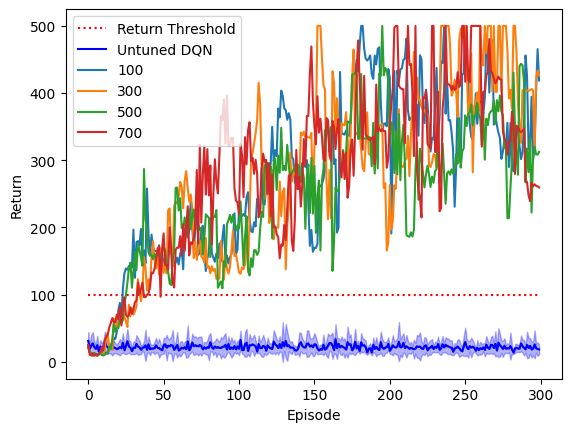

In [222]:
import json

# Assuming 'your_file.json' contains a JSON-formatted dictionary
json_file_path = 'performance_dict.json'

# Read JSON file
with open(json_file_path, 'r') as file:
    performance_dict = json.load(file)

# Print hyperparameter combinations
for key in performance_dict.keys():
    print(key)
    
# Plot untuned model for its performance
df = pd.read_csv('untuned.csv')  # read csv

# Extract columns
untuned_episodes = df['episodes']
untuned_means = df['means']
untuned_stds = df['stds']

# Plot the data
plt.plot(torch.arange(episode_duration), torch.full((episode_duration,), 100), color='red', linestyle='dotted', label='Return Threshold') # Return threshold at reward = 100
plt.plot(untuned_episodes, untuned_means, label='Untuned DQN', color='b') # untuned DQN for reference
plt.fill_between(untuned_episodes, untuned_means, untuned_means+untuned_stds, alpha=0.3, color='b')
plt.fill_between(untuned_episodes, untuned_means, untuned_means-untuned_stds, alpha=0.3, color='b')

# Labels to cycle through when plotting
labels = [
    '100',
    '300',
    '500',
    '700'
]

# Plot models with different hyperparameter variations
count = 0
print(type(performance_dict.values()))

for index, results in enumerate(performance_dict.values()):
    if index in [0,1,2,3]:
        results = torch.tensor(results)
        means = results.float().mean(0)
        stds = results.float().std(0)

        plt.plot(torch.arange(episode_duration), means, label=labels[count])
        plt.ylabel("Return")
        plt.xlabel("Episode")
        count += 1

plt.legend(loc='upper left')
plt.show()

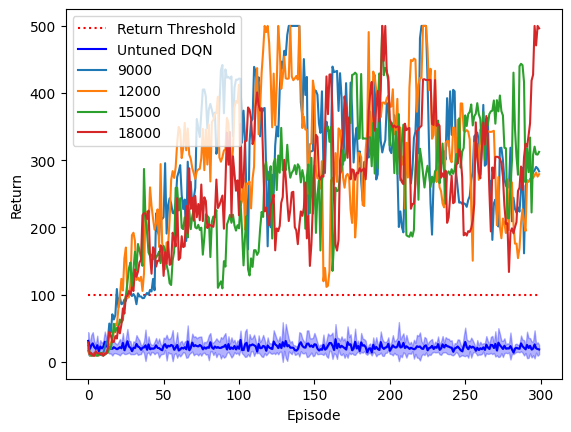

In [232]:
# Plot the data
plt.plot(torch.arange(episode_duration), torch.full((episode_duration,), 100), color='red', linestyle='dotted', label='Return Threshold') # Return threshold at reward = 100
plt.plot(untuned_episodes, untuned_means, label='Untuned DQN', color='b') # untuned DQN for reference
plt.fill_between(untuned_episodes, untuned_means, untuned_means+untuned_stds, alpha=0.3, color='b')
plt.fill_between(untuned_episodes, untuned_means, untuned_means-untuned_stds, alpha=0.3, color='b')

# Labels to cycle through when plotting
labels = [
    '9000',
    '12000',
    '15000',
    '18000',
]

# Plot models with different hyperparameter variations
count = 0
for index_list in [[4,5], [2], [6]]:
    for index, results in enumerate(performance_dict.values()):
        if index in index_list:
            results = torch.tensor(results)
            means = results.float().mean(0)
            stds = results.float().std(0)

            plt.plot(torch.arange(episode_duration), means, label=labels[count])
            plt.ylabel("Return")
            plt.xlabel("Episode")
            count += 1

plt.legend(loc='upper left')
plt.show()

# Save Optimal DQN as pickle

In [85]:
# Allow for further training beyond just 300 episodes
NUM_RUNS = 1
episode_duration = 500

final_dqn_results, final_dqn_model  = run_dqn(param_base)

# Specify the file path where you want to save the pickle file
pickle_file_path = 'final_dqn_model.pkl'

# Save the DQN model to a pickle file
with open(pickle_file_path, 'wb') as file:
    pickle.dump(final_dqn_model, file)

print(f'DQN model has been saved to {pickle_file_path}')


Starting run 1 of 1


/Users/kyhi2018/Desktop/Imperial/Reinforcement Learning/CW2/RL-Deep-Q-Learning/venv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 500
episode  100 / 500
episode  150 / 500
episode  200 / 500
episode  250 / 500
episode  300 / 500
episode  350 / 500
episode  400 / 500
episode  450 / 500
episode  500 / 500
Complete
DQN model has been saved to final_dqn_model.pkl


# Visualise DQN Policy as Grid

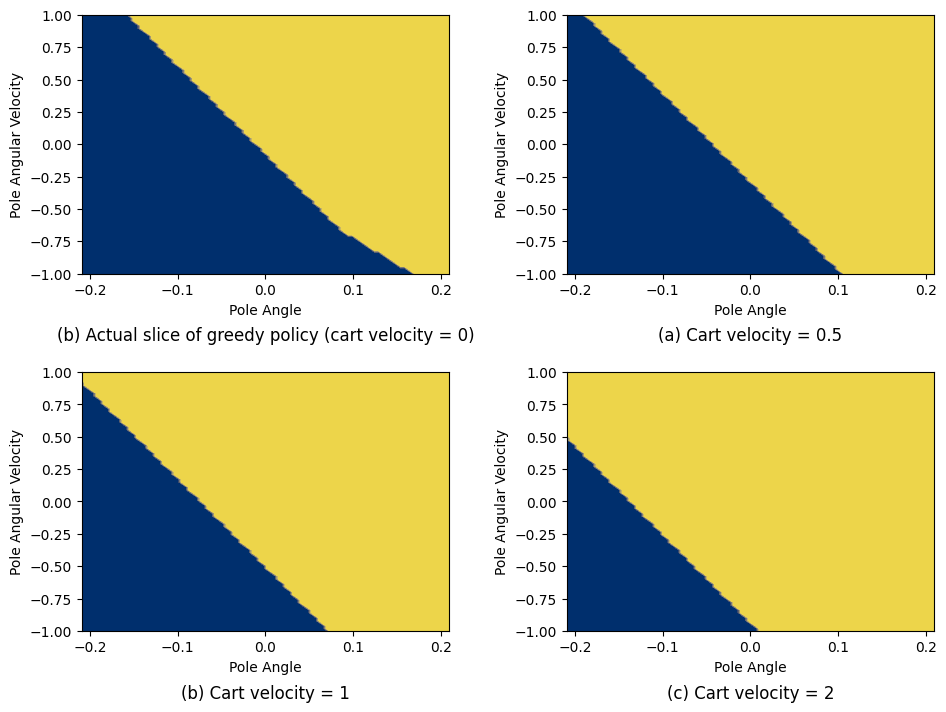

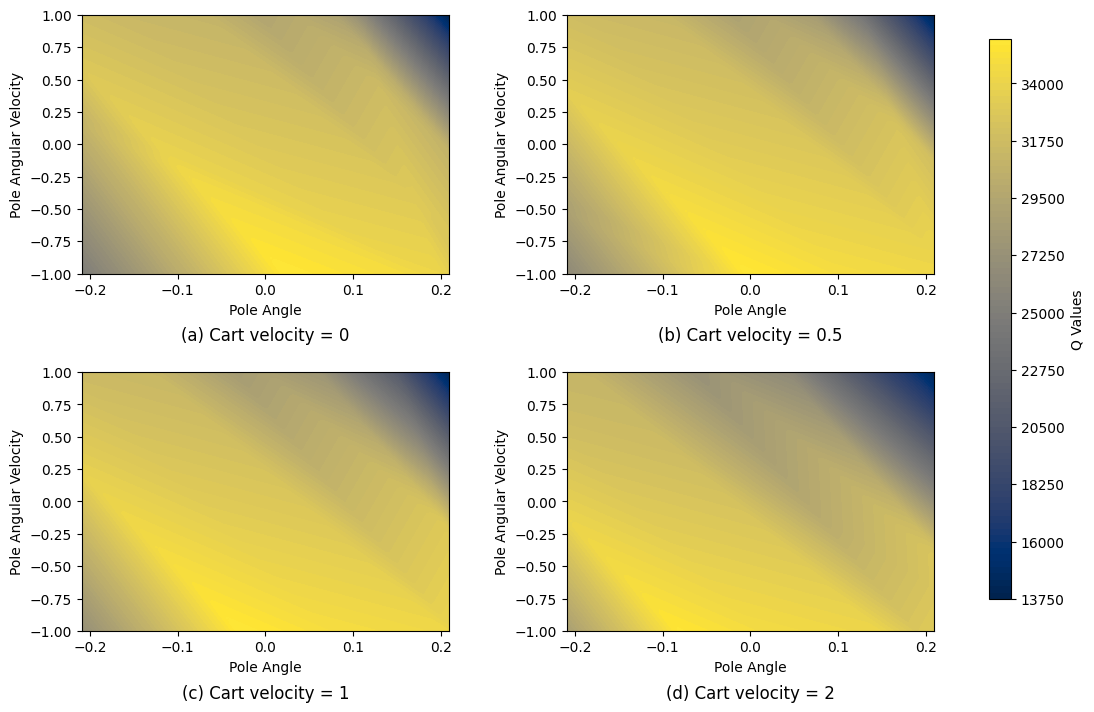

In [156]:
from matplotlib.gridspec import GridSpec

for q in [False, True]:
    fig = plt.figure(figsize=(11, 8))
    gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
    
    for velocity_idx, cart_velocity in enumerate([0, 0.5, 1, 2]):
        ax = fig.add_subplot(gs[velocity_idx // 2, velocity_idx % 2])

        angle_range = 0.2095  
        omega_range = 1       

        angle_samples = 100
        omega_samples = 100
        angles = torch.linspace(angle_range, -angle_range, angle_samples)
        omegas = torch.linspace(-omega_range, omega_range, omega_samples)

        greedy_q_array = torch.zeros((angle_samples, omega_samples))
        policy_array = torch.zeros((angle_samples, omega_samples))
        for i, angle in enumerate(angles):
            for k, omega in enumerate(omegas):
                state = torch.tensor([0, cart_velocity, angle, omega])
                with torch.no_grad():
                    q_vals = final_dqn_model(state)
                    greedy_action = q_vals.argmax()
                    greedy_q_array[i, k] = q_vals[greedy_action]
                    policy_array[i, k] = greedy_action

        if q:
            c = ax.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
            caption = chr(ord('a') + velocity_idx)  # Convert index to letter (a, b, c, d)
            ax.text(0.5, -0.24, f'({caption}) Cart velocity = {cart_velocity}', size=12, ha='center', va='center', transform=ax.transAxes)
        else:
            c = ax.contourf(angles, omegas, policy_array.T, cmap='cividis')
            if velocity_idx:
                caption = chr(ord('a') + velocity_idx-1)  # Convert index to letter (a, b, c, d)
                ax.text(0.5, -0.24, f'({caption}) Cart velocity = {cart_velocity}', size=12, ha='center', va='center', transform=ax.transAxes)
            else:
                ax.text(0.5, -0.24, f'(b) Actual slice of greedy policy (cart velocity = {cart_velocity})', size=12, ha='center', va='center', transform=ax.transAxes)

        ax.set_xlabel("Pole Angle")
        ax.set_ylabel("Pole Angular Velocity")

    # Add a common colorbar
    plt.subplots_adjust(wspace=0.32, hspace=0.38)  # Adjust vertical spacing
    if q:
        cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # [x, y, width, height]
        fig.colorbar(c, cax=cbar_ax, label='Q Values' if q else 'Policy')

    plt.show()

